In [1]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))    

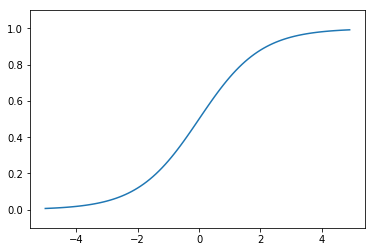

In [3]:
X = np.arange(-5.0, 5.0, 0.1)
Y = sigmoid(X)
plt.plot(X, Y)
plt.ylim(-0.1, 1.1)
plt.show()

In [4]:
def step_function(x):
    return np.array(x > 0, dtype=np.int)

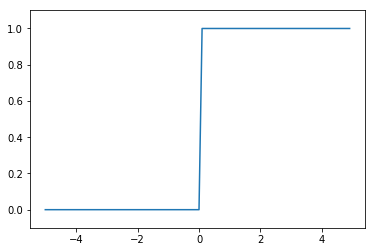

In [5]:
X = np.arange(-5.0, 5.0, 0.1)
Y = step_function(X)
plt.plot(X, Y)
plt.ylim(-0.1, 1.1)  # 図で描画するy軸の範囲を指定
plt.show()


In [6]:
def relu(x):
    return np.maximum(0, x)

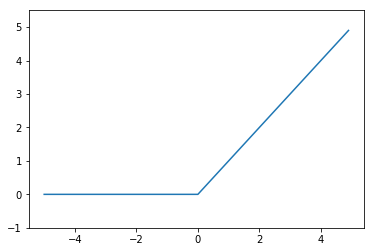

In [7]:
x = np.arange(-5.0, 5.0, 0.1)
y = relu(x)
plt.plot(x, y)
plt.ylim(-1.0, 5.5)
plt.show()

In [15]:
import os.path
import urllib.request
import gzip
import pickle
import os
import numpy as np


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = os.path.dirname(os.getcwd() )
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
        _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNISTデータセットの読み込み
    
    Parameters
    ----------
    normalize : 画像のピクセル値を0.0~1.0に正規化する
    one_hot_label : 
        one_hot_labelがTrueの場合、ラベルはone-hot配列として返す
        one-hot配列とは、たとえば[0,0,1,0,0,0,0,0,0,0]のような配列
    flatten : 画像を一次元配列に平にするかどうか 
    
    Returns
    -------
    (訓練画像, 訓練ラベル), (テスト画像, テストラベル)
    """
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 


In [16]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from PIL import Image


def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    pil_img.show()

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

img = x_train[0]
label = t_train[0]
print(label)  # 5

print(img.shape)  # (784,)
img = img.reshape(28, 28)  # 形状を元の画像サイズに変形
print(img.shape)  # (28, 28)

img_show(img)

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
5
(784,)
(28, 28)


In [19]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import pickle


def get_data():
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, flatten=True, one_hot_label=False)
    return x_test, t_test


def init_network():
    with open("sample_weight.pkl", 'rb') as f:
        network = pickle.load(f)
    return network


def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)

    return y

In [20]:
x, t = get_data()
network = init_network()
accuracy_cnt = 0
for i in range(len(x)):
    y = predict(network, x[i])
    p= np.argmax(y) # 最も確率の高い要素のインデックスを取得
    if p == t[i]:
        accuracy_cnt += 1

print("Accuracy:" + str(float(accuracy_cnt) / len(x)))

FileNotFoundError: [Errno 2] No such file or directory: 'sample_weight.pkl'

In [25]:
for v in key_file.values():
    print(v)

train-images-idx3-ubyte.gz
train-labels-idx1-ubyte.gz
t10k-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz


In [28]:

with open(os.getcwd() + "/sample_weight.pkl", 'rb') as f:
    network = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/arimuraterutoshi/mywork/gitspace/python_notebook/notebook/deep_learning_from_zero/chap3/sample_weight.pkl'

'/Users/arimuraterutoshi/mywork/gitspace/python_notebook/notebook/deep_learning_from_zero/chap3'